## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import cv2
import folium 
import rasterio
import glob
import math
from osgeo import gdal

import ee
import geemap

from rasterio.plot import show_hist
from pyproj import Proj, transform
from PIL import Image,ImageSequence
from tifffile import imread
import matplotlib.pyplot as plt
%matplotlib inline

Change the path to point to MARIDA dataset

In [3]:
path = './data/'

In [4]:
df = gpd.read_file(path+'shapefiles/'+"S2_12-1-17_16PCC.shp")
df.head()

id  conf  report                                           geometry
0   1     3       3  POLYGON ((361451.025 1750438.629, 361457.619 1...
1   1     3       3  POLYGON ((361450.812 1750449.317, 361459.001 1...
2   1     2       3  POLYGON ((362611.200 1751148.623, 362617.794 1...
3   1     1       3  POLYGON ((362690.856 1751198.608, 362697.556 1...
4   1     3       3  POLYGON ((364701.408 1751858.351, 364707.576 1...

In [5]:
df.crs

<Derived Projected CRS: EPSG:32616>
Name: WGS 84 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 90°W and 84°W, northern hemisphere between equator and 84°N, onshore and offshore. Belize. Canada - Manitoba; Nunavut; Ontario. Costa Rica. Cuba. Ecuador - Galapagos. El Salvador. Guatemala. Honduras. Mexico. Nicaragua. United States (USA).
- bounds: (-90.0, 0.0, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Returns transformed dataframe and Map(with Overlayed Polygons)

In [6]:
def displayOverlay(df):
    print(df.crs)
    # Project to NAD83 projected crs
    df = df.to_crs(epsg=2263)
    # Access the centroid attribute of each polygon
    df['centroid'] = df.centroid

    # Use WGS 84 (epsg:4326) as the geographic coordinate system
    df = df.to_crs(epsg=4326)
    df['centroid'] = df['centroid'].to_crs(epsg=4326)
#     df.plot()

    m = folium.Map(location=[df['centroid'][0].y,df['centroid'][0].x], zoom_start=10, tiles='CartoDB positron')

    for _, r in df.iterrows():
        # Without simplifying the representation of each borough,
        # the map might not be displayed
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': 'orange'})
        folium.Popup(r['id']).add_to(geo_j)
        geo_j.add_to(m)
    return df,m

In [7]:
trans_df,m = displayOverlay(df)

epsg:32616


In [8]:
m

### Returns RGB Composite Image

In [9]:
def showRGBImage(path):
    
    # Normalize bands into 0.0 - 0.1 scale
    def normalize(array):
        array_min, array_max = array.min(), array.max()
        array_min, array_max = 0, 0.1
        return (array - array_min) / (array_max - array_min)

    def getComposite(raster):
        # Convert to numpy arrays
        red = raster.read(4)
        green = raster.read(3)
        blue = raster.read(2)

        # Normalize band DN
        red_norm = normalize(red)
        blue_norm = normalize(blue)
        green_norm = normalize(green)

        # Stack bands
        nrg = np.dstack((red_norm, green_norm, blue_norm))
        return np.array(nrg,dtype=np.float32)
    
    fp=path
    raster = rasterio.open(fp)

    return getComposite(raster),raster

## Display All Images on a Given Day

In [10]:
def visualise(path,patch_name):
    files = glob.glob(path+patch_name+'/*[0-9].tif')
    if len(files)==0:
        print('No Files')
        return
    fig,ax= plt.subplots(math.ceil(len(files)/3),3,figsize=(20,30),sharex=True,sharey=True,squeeze=True)
    for i,file in enumerate(files):
        img,_ = showRGBImage(file)
        ax[i//3,i%3].imshow(img)
        ax[i//3,i%3].set_title(file.split('_')[-1])
            
    plt.tight_layout()
#         img1 = imread(file)
#         ax[i//4,i%4].imshow(img1[:,:,4],cmap='gray')

def getImgList(path,patch_name):
    files = sorted(glob.glob(path+patch_name+'/*[0-9].tif'))
    imgs = []
    for i,file in enumerate(files):
        img,_ = showRGBImage(file)
        imgs.append(img)
    return imgs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


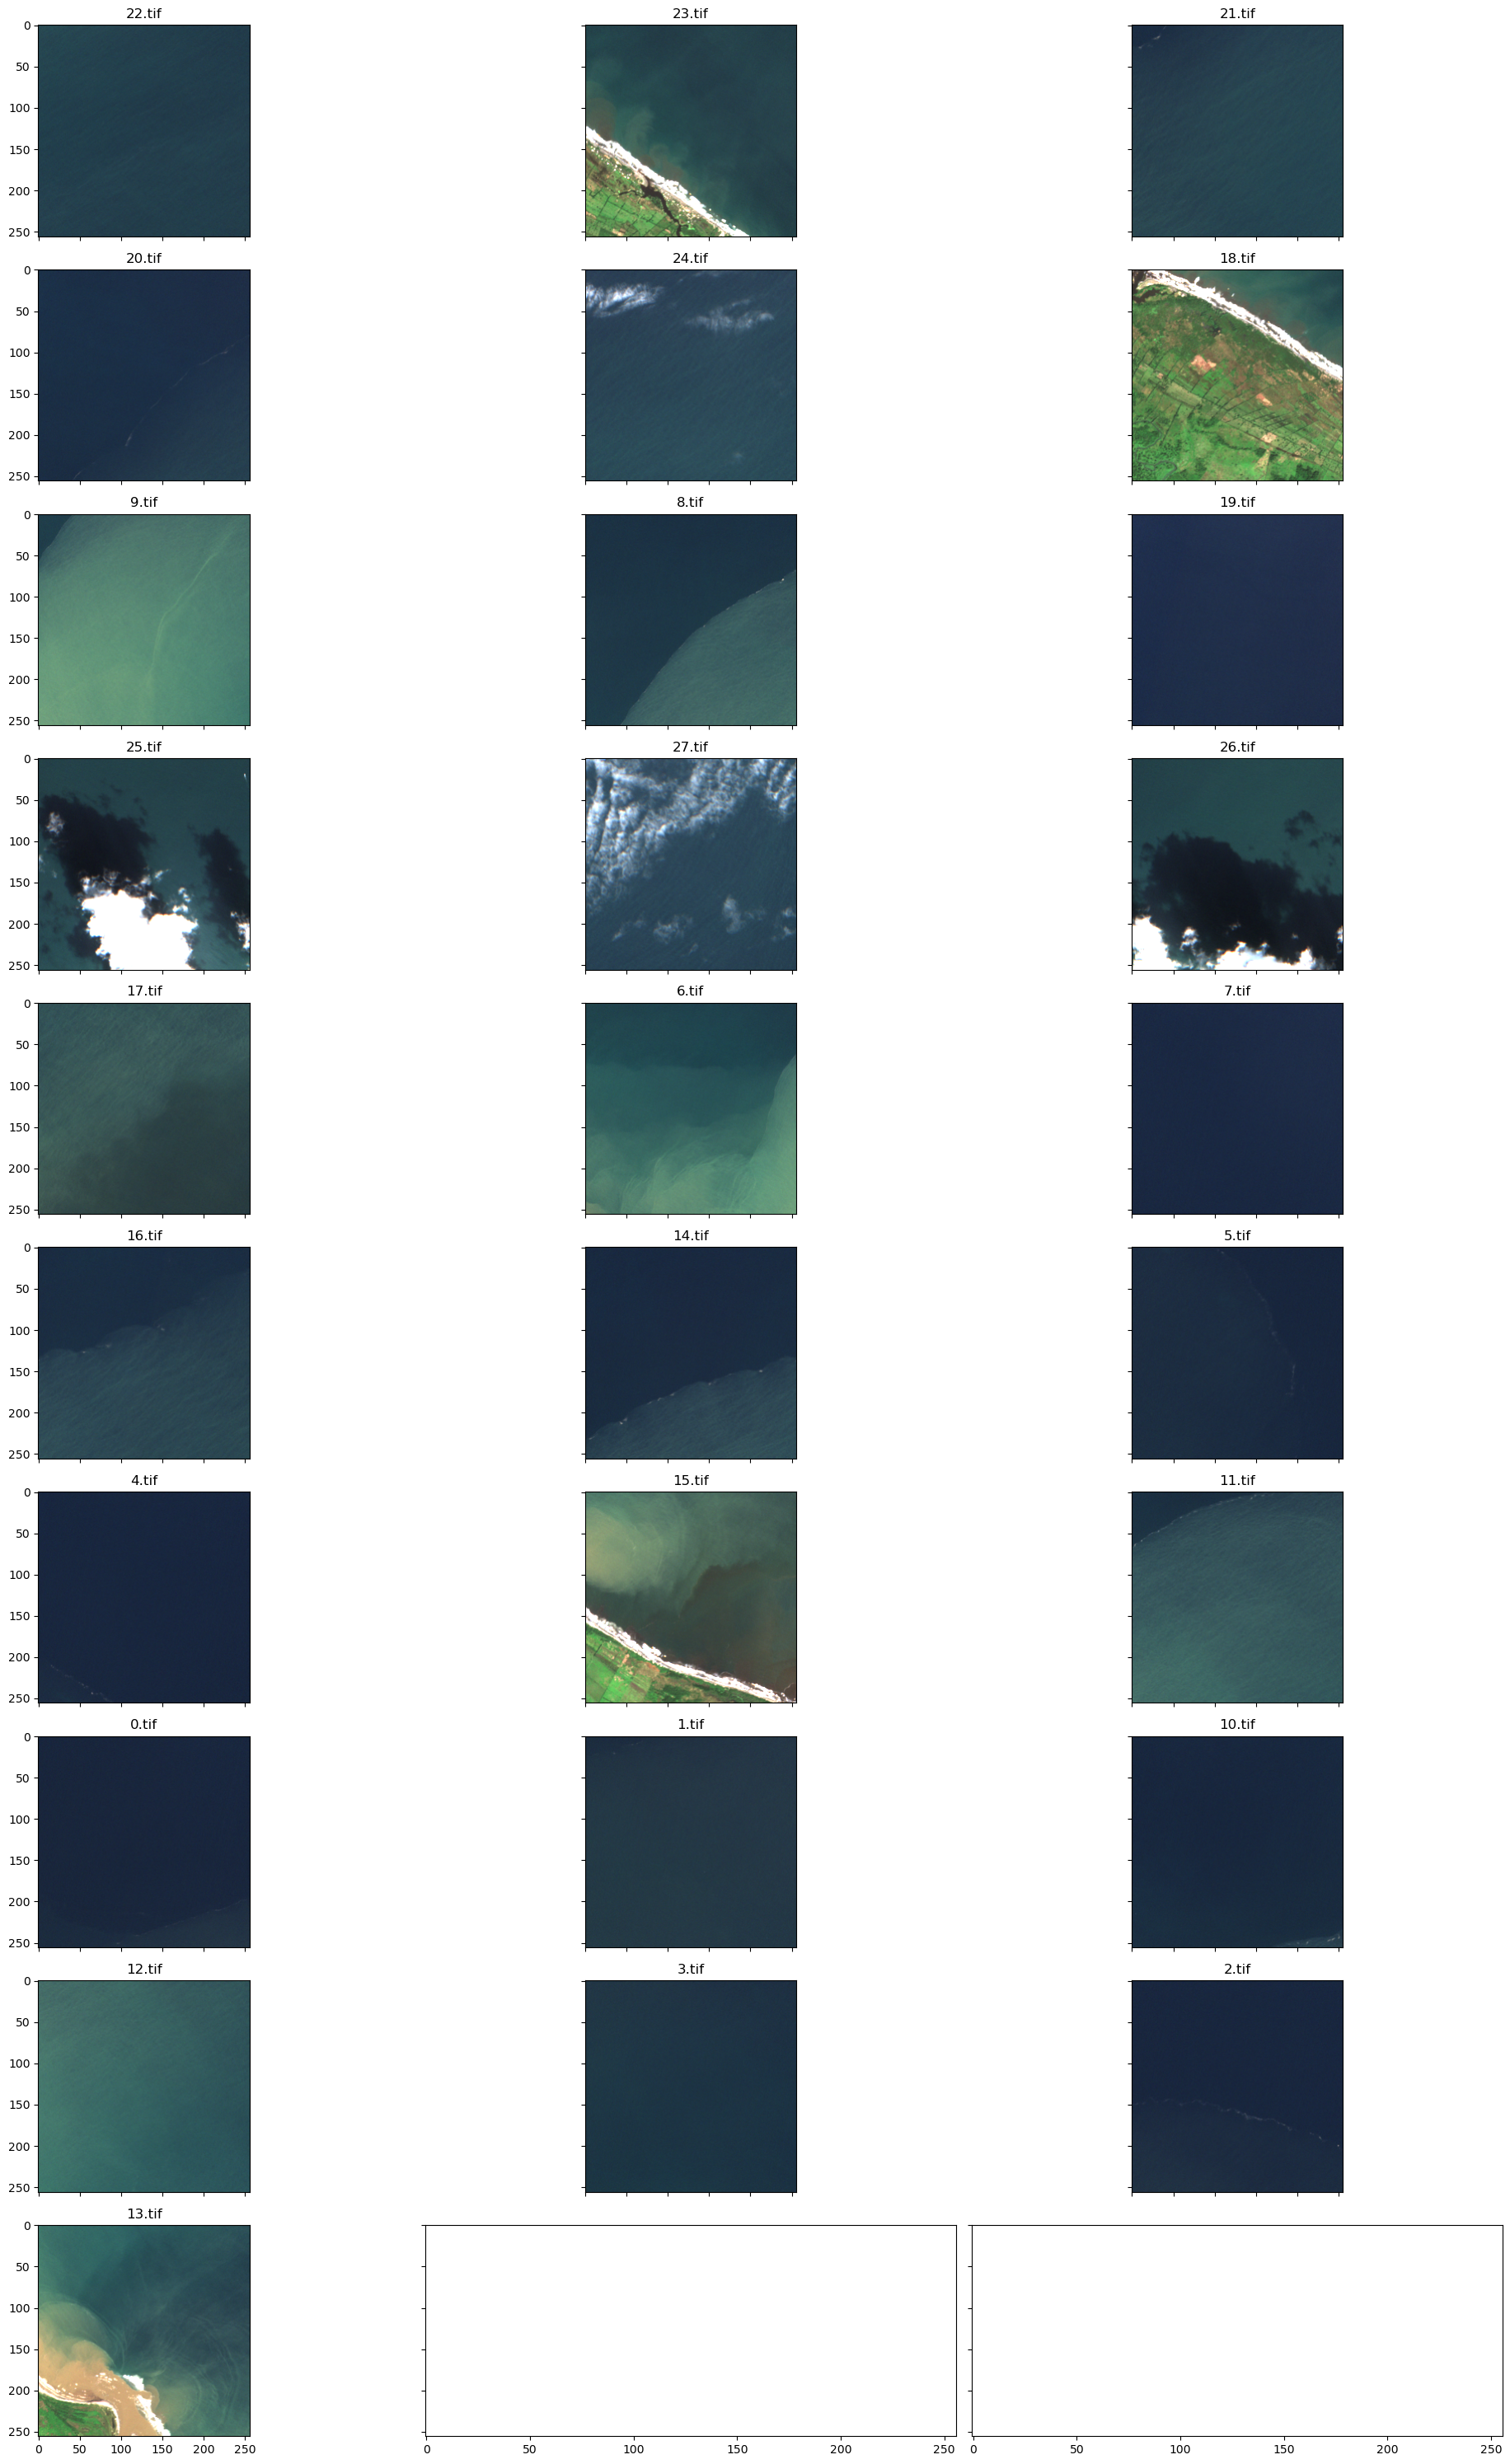

In [11]:
visualise('./data/patches/','S2_12-1-17_16PCC')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

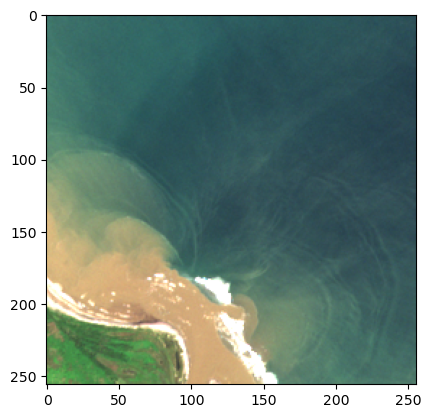

In [12]:
imgPath = f'{path}patches/S2_12-1-17_16PCC/S2_12-1-17_16PCC_13.tif'
img,_ = showRGBImage(imgPath)
plt.imshow(img)
cv2.imwrite('./data/temp/see.jpg',255*img)

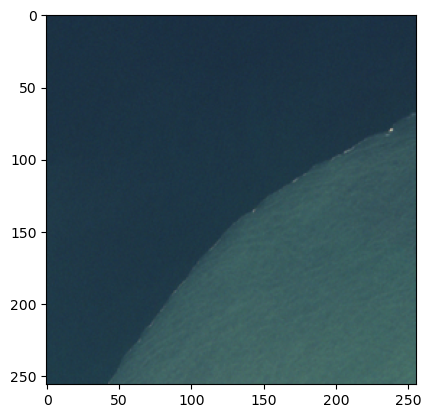

In [13]:
imgPath = f'{path}patches/S2_12-1-17_16PCC/S2_12-1-17_16PCC_8.tif'
img,raster = showRGBImage(imgPath)
plt.imshow(img)

### Get Coordinates of image centroid

In [14]:
# Define the input CRS
in_crs = Proj(init='epsg:32616')

# Define the output CRS
out_crs = Proj(init='epsg:4326')
def getCoord(affine):
    # Get the pixel coordinates of the image
    x, y = 128, 128

    # Get the geographic coordinates
    x_geo, y_geo = rasterio.transform.xy(affine, x, y)
#     print("Geographic Coordinates:",x_geo,y_geo)

    # Define the input coordinates
    x,y = x_geo,y_geo
    # Convert the coordinates
    x_out, y_out = transform(in_crs, out_crs, x, y)
#     print("Output Coordinates:",x_out,y_out)
    return (x_out,y_out)

/Users/hgumnur/miniconda3/envs/jup/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/hgumnur/miniconda3/envs/jup/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [15]:
# files = glob.glob(path+'patches/S2_12-1-17_16PCC/*[0-9].tif')
# coords=[]
# for i,file in enumerate(files):
#     coords.append(getCoord(affine))

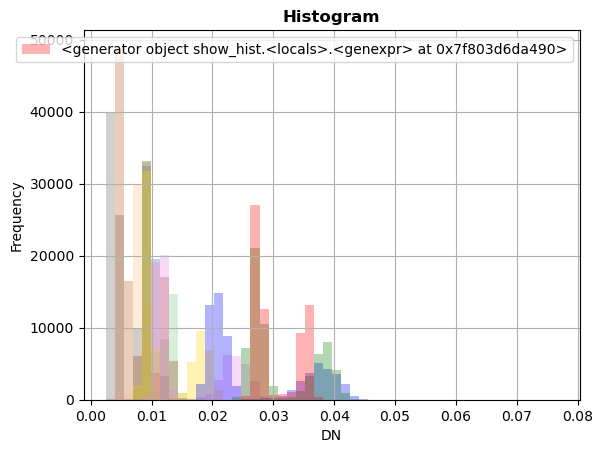

In [16]:
raster = rasterio.open(imgPath)
show_hist(raster, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', title="Histogram")

# GEE Visualization


In [17]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

## GEE Authentication

In [18]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [19]:
sent2 = ee.ImageCollection("COPERNICUS/S2")
lat,long = trans_df['centroid'][0].x,trans_df['centroid'][1].y
poi = ee.Geometry.Point([lat,long])
img = ee.Image(sent2.filterDate("2017-01-12", "2017-01-13").filterBounds(poi).sort("CLOUD_COVERAGE_ASSESSMENT").first())

In [20]:
# Select a specific band and dates for land cover.
# img = lc.select('B4').filterDate(i_date).first()

# Set visualization parameters for land cover.
trueColour = {
    'bands': ["B4", "B3", "B2"],
    'min': 0,
    'max': 3000
    }

# Create a map.
my_map = folium.Map(location=[long, lat], zoom_start=9)

# Add the land cover to the map object.
my_map.add_ee_layer(img, trueColour, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [22]:
df.crs

<Derived Projected CRS: EPSG:32616>
Name: WGS 84 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 90°W and 84°W, northern hemisphere between equator and 84°N, onshore and offshore. Belize. Canada - Manitoba; Nunavut; Ontario. Costa Rica. Cuba. Ecuador - Galapagos. El Salvador. Guatemala. Honduras. Mexico. Nicaragua. United States (USA).
- bounds: (-90.0, 0.0, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
trans_df

id  conf  report                                           geometry  \
0     1     3       3  POLYGON ((-88.29376 15.82892, -88.29370 15.828...   
1     1     3       3  POLYGON ((-88.29377 15.82902, -88.29369 15.829...   
2     1     2       3  POLYGON ((-88.28297 15.83540, -88.28291 15.835...   
3     1     1       3  POLYGON ((-88.28223 15.83586, -88.28217 15.835...   
4     1     3       3  POLYGON ((-88.26350 15.84193, -88.26344 15.841...   
..   ..   ...     ...                                                ...   
103   6     1       3  POLYGON ((-88.09170 15.88306, -88.09137 15.883...   
104   7     1       3  POLYGON ((-88.08595 15.87514, -88.08573 15.875...   
105   6     1       3  POLYGON ((-88.07619 15.87363, -88.07611 15.873...   
106   7     1       3  POLYGON ((-88.07445 15.87375, -88.07436 15.873...   
107   6     1       3  POLYGON ((-88.07426 15.87177, -88.07424 15.871...   

                       centroid  
0    POINT (-88.29373 15.82889)  
1    POINT (-88.29373 15.82898)  
2    POINT (-88.28294 15.83537)  
3    POINT (-88.28219 15.83583)  
4    POINT (-88.26347 15.84190)  
..                          ...  
103  POINT (-88.08932 15.88222)  
104  POINT (-88.08584 15.87509)  
105  POINT (-88.07591 15.87320)  
106  POINT (-88.07440 15.87369)  
107  POINT (-88.07369 15.87164)  

[108 rows x 5 columns]

In [154]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [-88.7160810011231,15.413890521139999],
[-87.2878583448731,15.413890521139999],
[-87.2878583448731,16.438643230201333],
[-88.7160810011231,16.438643230201333],
[-88.7160810011231,15.413890521139999]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

In [155]:
json = trans_df['geometry'].to_json()

In [156]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [-88.29376282961574, 15.828922648238498], 
            [-88.29370126916083, 15.828923015352462], 
            [-88.29369499365329, 15.828873067500592], 
            [-88.29369493249109, 15.828863455312462], 
            [-88.2937564684621, 15.828859243326514], 
            [-88.29376282961574, 15.828922648238498]
            ]
            ]
            }, 
            "bbox": 
            [
              -88.29376282961574, 15.828859243326514, 
            -88.29369493249109, 15.828923015352462
            ]
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [173]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.473892211914062,
              49.98081240937428
            ],
            [
              8.658599853515625,
              49.98081240937428
            ],
            [
              8.658599853515625,
              50.06066538593667
            ],
            [
              8.473892211914062,
              50.06066538593667
            ],
            [
              8.473892211914062,
              49.98081240937428
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.534317016601562,
              50.021637833966786
            ],
            [
              8.530540466308594,
              49.99780882512238
            ],
            [
              8.564186096191406,
              50.00663576154257
            ],
            [
              8.578605651855469,
              50.019431940583104
            ],
            [
              8.534317016601562,
              50.021637833966786
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [174]:
# im_coll = (sent2.filterBounds(aoi).filterDate(ee.Date('2017-01-12'),ee.Date('2018-08-24')).sort('system:time_start'))
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi)
                .filterDate(ee.Date('2020-08-01'),ee.Date('2020-08-31'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 15))
                .sort('system:time_start'))

In [175]:
import time
acq_times = im_coll.aggregate_array('system:time_start').getInfo()
len([time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times])

5

In [176]:
# im_list = im_coll.toList(im_coll.size())
# im1 = ee.Image(im_list.get(1)).select('B2').clip(aoi_sub)
# im2 = ee.Image(im_list.get(470)).select('B2').clip(aoi_sub)

im_list = im_coll.toList(im_coll.size())
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi_sub)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi_sub)

In [166]:
import IPython.display as disp
import requests
from io import BytesIO
visualisation_params = { 
  'min': 0.0,
  'max': 10,
  'dimensions': 620,
}

In [177]:
ratio = im1.divide(im2)
url = ratio.getThumbURL({'min': 0, 'max': 10})
disp.Image(url=url, width=800)

In [170]:
hist = ratio.reduceRegion(ee.Reducer.fixedHistogram(0, 5, 500), aoi_sub).get('B2').getInfo()
mean = ratio.reduceRegion(ee.Reducer.mean(), aoi_sub).get('B2').getInfo()
variance = ratio.reduceRegion(ee.Reducer.variance(), aoi_sub).get('B2').getInfo()

In [171]:
print(hist)

None


In [152]:
a = np.array(hist)
x = a[:,0]
y = a[:, 1] / np.sum(a[:, 1])
plt.grid()
plt.plot(x, y, '.')
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed